In [14]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

from PIL import Image

#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

In [ ]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:37<00:00, 77.1MB/s]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# IMAGE_SIZE = 224
# BATCH_SIZE = 4
# NUM_CLASSES = 20
# DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training" #"/content/VOCdevkit"
# NUM_TRAIN_IMAGES = 1000
# NUM_VAL_IMAGES = 50

# train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
# train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
# val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
#     NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
# ]
# val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
#     NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
# ]



# def read_image(image_path, mask=False):
#     image = tf.io.read_file(image_path)
#     if mask:
#         image = tf.image.decode_png(image, channels=1)
#         image.set_shape([None, None, 1])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     else:
#         image = tf.image.decode_jpeg(image, channels=3)
#         image.set_shape([None, None, 3])
#         image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
#         image = image / 127.5 - 1
#     return image


# def load_data(image_list, mask_list):
#     image = read_image(image_list)
#     mask = read_image(mask_list, mask=True)
#     return image, mask


# def data_generator(image_list, mask_list):
#     dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
#     dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#     return dataset


# train_dataset = data_generator(train_images, train_masks)
# val_dataset = data_generator(val_images, val_masks)

# print("Train Dataset:", train_dataset)
# print("Val Dataset:", val_dataset)


Train Dataset: <BatchDataset shapes: ((4, 224, 224, 3), (4, 224, 224, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, 224, 224, 3), (4, 224, 224, 1)), types: (tf.float32, tf.float32)>


In [3]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


In [27]:
def _convert_to_segmentation_mask(mask):
    # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
    #
    # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
    # encode the pixel's class.
    #
    # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
    # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
    # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
    for label_index, label in enumerate(VOC_COLORMAP):
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

In [28]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR_VOC = "/content/VOCdevkit"
# NUM_TRAIN_IMAGES = 1000
# NUM_VAL_IMAGES = 50


with open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt') as f:
    train_lines = f.read().splitlines()

train_images = train_lines.copy()
train_masks = train_lines.copy()
for i in range(len(train_lines)):
    train_images[i] = os.path.join('/content/VOCdevkit/VOC2012/JPEGImages', train_lines[i] + '.jpg')
    train_masks[i] = os.path.join('/content/VOCdevkit/VOC2012/SegmentationClass', train_lines[i] + '.png')
    #img = np.array(Image.open(train_masks[i]))
    #print(img.shape)
    #seg_mask = _convert_to_segmentation_mask(img)
    #print(seg_mask.shape)
    #Image.fromarray()
    #im1 = seg_mask.save("/content/VOCdevkit/VOC2012/SegmentationClass_1" + train_masks[i] + ".jpg")
print(train_images)
print(train_masks)


NUM_TRAIN_IMAGES = len(train_lines)

with open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt') as f:
    val_lines = f.read().splitlines()

val_images = val_lines.copy()
val_masks = val_lines.copy()
for i in range(len(val_lines)):
    val_images[i] = os.path.join('/content/VOCdevkit/VOC2012/JPEGImages', val_lines[i] + '.jpg')
    val_masks[i] = os.path.join('/content/VOCdevkit/VOC2012/SegmentationClass', val_lines[i] + '.png')
    # img = np.array(Image.open(val_masks[i]))
    # seg_mask = Image.fromarray(_convert_to_segmentation_mask(img))
    # im1 = seg_mask.save("/content/VOCdevkit/VOC2012/SegmentationClass_1" + val_masks[i] + ".jpg")

NUM_VAL_IMAGES = len(val_lines)

['/content/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000039.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000063.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000068.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000121.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000170.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000241.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000243.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000250.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000256.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000333.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000363.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000364.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000392.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000480.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000504.jpg', '/content/VOCdevkit/VOC2012/JPEGImages/2007_000515.jpg', '/content/VOCdevkit/VOC2012/JP

In [33]:
voc_colormap = tf.Tensor(VOC_COLORMAP, (21, 3), dtype=int)

TypeError: ignored

In [30]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        #image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

train_dataset_VOC = data_generator(train_images, train_masks)
val_dataset_VOC = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset_VOC)
print("Val Dataset:", val_dataset_VOC)

TypeError: ignored

Mask mean
(4, 224, 224, 1)
tf.Tensor(
[[1.4577398 0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]], shape=(30, 50), dtype=float32)


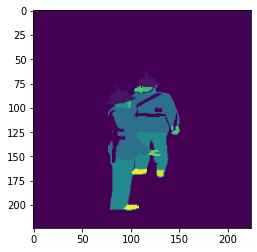

------------------------------------------
Mask mean
(4, 224, 224, 1)
tf.Tensor(
[[5.        5.        5.        ... 5.        5.        5.       ]
 [5.        5.        5.        ... 5.        5.        5.       ]
 [8.205383  5.        5.        ... 5.        5.        5.       ]
 ...
 [9.        9.        9.        ... 5.        5.        2.2261739]
 [9.        9.        9.        ... 5.        3.9892292 0.       ]
 [9.        9.        9.        ... 4.9957232 0.        0.       ]], shape=(30, 50), dtype=float32)


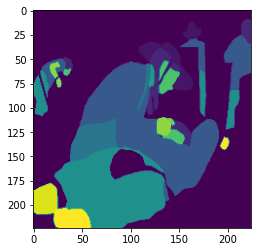

------------------------------------------
Mask mean
(4, 224, 224, 1)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(30, 50), dtype=float32)


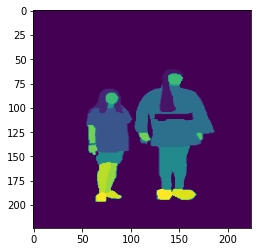

------------------------------------------
Mask mean
(4, 224, 224, 1)
tf.Tensor(
[[14. 14. 14. ...  6.  6.  6.]
 [14. 14. 14. ...  6.  6.  6.]
 [14. 14. 14. ...  6.  6.  6.]
 ...
 [ 6.  6.  6. ...  6.  6.  6.]
 [ 6.  6.  6. ...  6.  6.  6.]
 [ 6.  6.  6. ...  6.  6.  6.]], shape=(30, 50), dtype=float32)


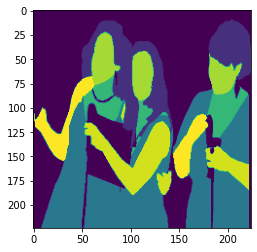

------------------------------------------
Mask mean
(4, 224, 224, 1)
tf.Tensor(
[[ 0.  0.  0. ... 14. 14. 14.]
 [ 0.  0.  0. ... 14. 14. 14.]
 [ 0.  0.  0. ... 14. 14. 14.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]], shape=(30, 50), dtype=float32)


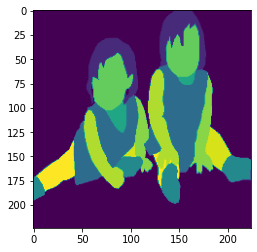

------------------------------------------


In [ ]:
count = 0
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import matplotlib.pyplot as plt
for img,mask in train_dataset:
  # print(mask)
  print('Mask mean')
  print(mask.shape)
  print(mask[0][150:180, 120:170, 0])
  #plt.imshow((img[0]).astype(np.uint8))
  #plt.show()
  plt.imshow(mask[0][:,:,0])
  plt.show()
  #print(tf.reduce_mean(mask))
  # print('Unique mask values')
  #print(tf.unique(tf.reshape(mask[0],[-1])))
  #print(tf.unique(mask[0]))
  #print('image mean')
  #print(tf.reduce_mean(img))
  #print(img)
  #print(mask)
  print('------------------------------------------')
  count+=1
  if count == 5:
    break

## Rough model for DeepLabV3


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
# def DeeplabV3Plus_1(image_size, num_classes):
#     model_input = keras.Input(shape=(image_size, image_size, 3))
#     resnet50 = keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_tensor=model_input
#     )
#     resnet50.summary()
#     x = resnet50.get_layer("conv4_block6_2_relu").output
#     print("#########################################################")
#     print(x.shape)
#     x = DilatedSpatialPyramidPooling(x)

#     input_a = layers.UpSampling2D(
#         size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
#         interpolation="bilinear",
#     )(x)
    
#     print(input_a.shape)
#     input_b = resnet50.get_layer("conv2_block3_2_relu").output
#     print("#########################################################")
#     print(input_b.shape)
#     input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
#     print("#########################################################")
#     print(input_b.shape)

#     x = layers.Concatenate(axis=-1)([input_a, input_b])
#     x = convolution_block(x)
#     x = convolution_block(x)
#     x = layers.UpSampling2D(
#         size=(image_size // x.shape[1], image_size // x.shape[2]),
#         interpolation="bilinear",
#     )(x)
#     model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
#     return keras.Model(inputs=model_input, outputs=model_output)


# model = DeeplabV3Plus_1(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# #model.summary()

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))

    model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=False, weights='imagenet', 
                                            input_tensor=model_input, pooling=None, classes=1000)
    
    #MNetV3.summary()

    x = model.get_layer("block_6_expand_BN").output # 
    print(x.shape)
    x = DilatedSpatialPyramidPooling(x)

    print("x")
    print(x.shape)
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)

    print("input_a")
    print(input_a.shape)
    input_b = model.get_layer("block_2_project_BN").output  #block_3_expand_relu
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    print("input_b")
    print(input_b.shape)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

(None, 28, 28, 192)
x
(None, 28, 28, 256)
input_a
(None, 56, 56, 256)
input_b
(None, 56, 56, 48)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]               

In [ ]:
count = 0
import matplotlib.pyplot as plt
for img,mask in train_dataset_VOC:
  # print(mask)
  print('Mask mean')
  print(mask.shape)
  out = model.predict(img)
  print(out)
  #plt.imshow(out[0][:,:,0])
  #plt.imshow(mask[0][:,:,0])
  #plt.show()
  #print(tf.reduce_mean(mask))
  # print('Unique mask values')
  #print(tf.unique(tf.reshape(mask[0],[-1])))
  #print(tf.unique(mask[0]))
  #print('image mean')
  #print(tf.reduce_mean(img))
  #print(img)
  #print(mask)
  print('------------------------------------------')
  count+=1
  if count == 5:
    break

Mask mean
(4, 224, 224, 1)
[[[[-4.4022274   0.05231807 -1.8782163  ... -0.8709879  -4.022687
     0.3224684 ]
   [-4.4022274   0.05231807 -1.8782163  ... -0.8709879  -4.022687
     0.3224684 ]
   [-4.3409386  -0.04744412 -1.9084365  ... -0.9738644  -3.9968524
     0.21707866]
   ...
   [-0.94105285  0.76259106 -1.4647111  ... -1.7800999  -4.0083914
    -1.6970532 ]
   [-0.740648    0.5730367  -1.6309607  ... -1.6669357  -3.8844519
    -1.3888841 ]
   [-0.740648    0.5730367  -1.6309607  ... -1.6669357  -3.8844519
    -1.3888841 ]]

  [[-4.4022274   0.05231807 -1.8782163  ... -0.8709879  -4.022687
     0.3224684 ]
   [-4.4022274   0.05231807 -1.8782163  ... -0.8709879  -4.022687
     0.3224684 ]
   [-4.3409386  -0.04744412 -1.9084365  ... -0.9738644  -3.9968524
     0.21707866]
   ...
   [-0.94105285  0.76259106 -1.4647111  ... -1.7800999  -4.0083914
    -1.6970532 ]
   [-0.740648    0.5730367  -1.6309607  ... -1.6669357  -3.8844519
    -1.3888841 ]
   [-0.740648    0.5730367  -1.630960

In [ ]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        PATH = 'drive/MyDrive/PRT-project/DLV3-HumanParsingDS-epoch-%d.h5'%(epoch)
        if epoch == 20:  # or save after some epoch, each k-th epoch etc.
            self.model.save(PATH)


In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=loss,
    metrics=["accuracy"],
)
saver = CustomSaver()
history = model.fit(train_dataset_VOC, validation_data=val_dataset_VOC, callbacks=[saver], epochs=100)


Epoch 1/100
 21/366 [>.............................] - ETA: 1:03 - loss: nan - accuracy: 0.6569

KeyboardInterrupt: ignored

In [4]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar 

--2021-11-03 00:43:06--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  11.3MB/s    in 2m 55s  

2021-11-03 00:46:01 (10.9 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [5]:
%%bash
tar -xvf /content/VOCtrainval_11-May-2012.tar

VOCdevkit/
VOCdevkit/VOC2012/
VOCdevkit/VOC2012/Annotations/
VOCdevkit/VOC2012/Annotations/2007_000027.xml
VOCdevkit/VOC2012/Annotations/2007_000032.xml
VOCdevkit/VOC2012/Annotations/2007_000033.xml
VOCdevkit/VOC2012/Annotations/2007_000039.xml
VOCdevkit/VOC2012/Annotations/2007_000042.xml
VOCdevkit/VOC2012/Annotations/2007_000061.xml
VOCdevkit/VOC2012/Annotations/2007_000063.xml
VOCdevkit/VOC2012/Annotations/2007_000068.xml
VOCdevkit/VOC2012/Annotations/2007_000121.xml
VOCdevkit/VOC2012/Annotations/2007_000123.xml
VOCdevkit/VOC2012/Annotations/2007_000129.xml
VOCdevkit/VOC2012/Annotations/2007_000170.xml
VOCdevkit/VOC2012/Annotations/2007_000175.xml
VOCdevkit/VOC2012/Annotations/2007_000187.xml
VOCdevkit/VOC2012/Annotations/2007_000241.xml
VOCdevkit/VOC2012/Annotations/2007_000243.xml
VOCdevkit/VOC2012/Annotations/2007_000250.xml
VOCdevkit/VOC2012/Annotations/2007_000256.xml
VOCdevkit/VOC2012/Annotations/2007_000272.xml
VOCdevkit/VOC2012/Annotations/2007_000323.xml
VOCdevkit/VOC2012/A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


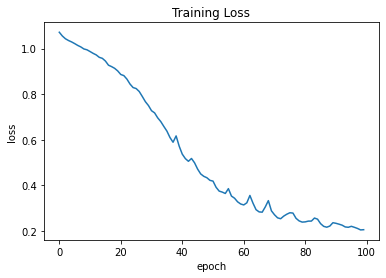

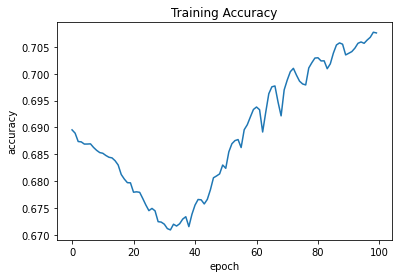

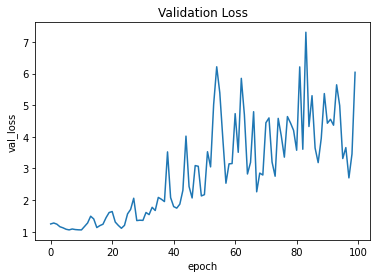

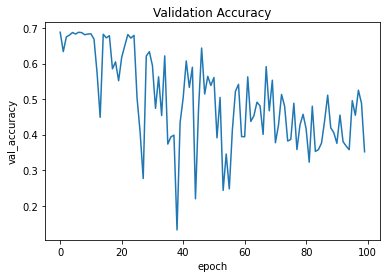

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.outputs

[<KerasTensor: shape=(None, 512, 512, 20) dtype=float32 (created by layer 'conv2d_9')>]